In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Desktop/flight_data.csv", index_col = 'Unnamed: 0') # Importing the data

In [3]:
df.head() # First 5 elements

,Airline name,Departure city,Arrival city,Departure time,Arrival time,Total stops,Price
0,AirAsia,New Delhi,Mumbai,09:35,20:35,1 stop via Bengaluru,"₹ 5,953"
1,Go First,New Delhi,Mumbai,02:00,04:15,Non stop,"₹ 5,954"
2,Go First,New Delhi,Mumbai,07:00,09:10,Non stop,"₹ 5,954"
3,Go First,New Delhi,Mumbai,08:00,10:10,Non stop,"₹ 5,954"
4,Go First,New Delhi,Mumbai,10:30,12:50,Non stop,"₹ 5,954"


In [4]:
df.tail() # Bottom 5 elements

,Airline name,Departure city,Arrival city,Departure time,Arrival time,Total stops,Price
1548,Air India,Pune,Ahmedabad,12:35,19:25,"2 stop via Bhopal,New Delhi","₹ 10,998"
1549,Spicejet,Pune,Ahmedabad,08:40,10:05,Non stop,"₹ 11,102"
1550,Air India,Pune,Ahmedabad,18:50,06:20,1 stop via New Delhi,"₹ 14,253"
1551,Air India,Pune,Ahmedabad,12:35,06:20,"2 stop via Bhopal,New Delhi","₹ 16,305"
1552,Air India,Pune,Ahmedabad,07:40,19:25,1 stop via New Delhi,"₹ 16,353"


In [5]:
df.shape # We have 1553 rows and 7 coulmns

(1553, 7)

In [6]:
df.nunique()

Airline name       21
Departure city      9
Arrival city        9
Departure time    243
Arrival time      249
Total stops        61
Price             541
dtype: int64

In [7]:
df.isnull().sum() # no null values

Airline name      0
Departure city    0
Arrival city      0
Departure time    0
Arrival time      0
Total stops       0
Price             0
dtype: int64

In [8]:
df.info() # every column data type is an object right now; they will be converted at a later date to float date time etc.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1553 entries, 0 to 1552
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Airline name    1553 non-null   object
 1   Departure city  1553 non-null   object
 2   Arrival city    1553 non-null   object
 3   Departure time  1553 non-null   object
 4   Arrival time    1553 non-null   object
 5   Total stops     1553 non-null   object
 6   Price           1553 non-null   object
dtypes: object(7)
memory usage: 97.1+ KB


All of the data was collected on Dec 6 at 20:00 hours for the following day journey i.e for dec 7th; for this reason I have not added the date of journey column, but will be using another metric to predict price volatility.

Before any EDA can be done on this data, I need to extract the route and stops from the total stops column as it contains both information.

In [9]:
df = df.rename(columns={'Total stops': 'Route dummy'}) # renaming the coulumn as it contains data of stops as well as the orute

In [10]:
df['Total stops'] = df['Route dummy'].str.replace('Non', '0') # rpelacing non stop with 0 stops

In [11]:
df['Total stops'].value_counts()

0 stop                          806
1 stop via Bengaluru            218
1 stop via New Delhi            133
1 stop via Mumbai                64
1 stop via Chennai               58
                               ... 
2 stop via Bengaluru,Mysore       1
2 stop via Guwahati,Agartala      1
1 stop via Jodhpur                1
2 stop via Hubli,Chennai          1
2 stop via Jaipur,Bengaluru       1
Name: Total stops, Length: 61, dtype: int64

In [12]:
# vc_ = df['Total stops'].value_counts()
# bv_ = df['Total stops'].isin(vc_.index[vc_<30])

# df.loc[bv_, 'Total stops'] = '1' # as very few flights have 

In [13]:
df['Total stops'] = df['Total stops'].str[0].astype(int)

In [14]:
df.head()

,Airline name,Departure city,Arrival city,Departure time,Arrival time,Route dummy,Price,Total stops
0,AirAsia,New Delhi,Mumbai,09:35,20:35,1 stop via Bengaluru,"₹ 5,953",1
1,Go First,New Delhi,Mumbai,02:00,04:15,Non stop,"₹ 5,954",0
2,Go First,New Delhi,Mumbai,07:00,09:10,Non stop,"₹ 5,954",0
3,Go First,New Delhi,Mumbai,08:00,10:10,Non stop,"₹ 5,954",0
4,Go First,New Delhi,Mumbai,10:30,12:50,Non stop,"₹ 5,954",0


In [15]:
df['Route dummy'] = df['Route dummy'].astype(str).str[10:]
df.head() # replacing route with actual route

,Airline name,Departure city,Arrival city,Departure time,Arrival time,Route dummy,Price,Total stops
0,AirAsia,New Delhi,Mumbai,09:35,20:35,Bengaluru,"₹ 5,953",1
1,Go First,New Delhi,Mumbai,02:00,04:15,,"₹ 5,954",0
2,Go First,New Delhi,Mumbai,07:00,09:10,,"₹ 5,954",0
3,Go First,New Delhi,Mumbai,08:00,10:10,,"₹ 5,954",0
4,Go First,New Delhi,Mumbai,10:30,12:50,,"₹ 5,954",0


In [16]:
df['Price'] = df['Price'].str[2:] # Removing the rupee symbol and switching price to integer value
df['Price'] = df['Price'].str.replace(',','')
df['Price'] = df['Price'].astype(int)

In [17]:
s = pd.to_datetime(df['Departure time'],format='%H:%M') # converting the departure time and arrival time to minutes
df['departure minute'] = s.dt.hour*60 + s.dt.minute

p = pd.to_datetime(df['Arrival time'],format='%H:%M')
df['arrival minute'] = p.dt.hour*60 + p.dt.minute

In [18]:
df['duration'] = '' # initiating empty duration coulmn

In [19]:
for ind in df.index:
    if df['arrival minute'][ind] > df['departure minute'][ind] and df['Total stops'][ind]<2:
        df['duration'][ind] = df['arrival minute'][ind] - df['departure minute'][ind]
        
    else:
        df['duration'][ind] = df['arrival minute'][ind] - df['departure minute'][ind] + 1440

In [20]:
df['duration'] = df['duration'].astype(int)

This is the metric airlines use, the phase of day, so I have converted it similarly.

In [21]:
df['Departure'] = df['departure minute'].apply(lambda date: "Early Morning" if 0 <= date <= 360 else "Late Morning" if 361 <= date <= 720  else "Early Evening" if 721 <= date <= 1080 else "Late Evening")
df['Arrival'] = df['arrival minute'].apply(lambda date: "Early Morning" if 0 <= date <= 360 else "Late Morning" if 361 <= date <= 720  else "Early Evening" if 721 <= date <= 1080 else "Late Evening")

In [22]:
df.drop(['Departure time','Arrival time','departure minute','arrival minute'], axis = 1, inplace = True)

In [23]:
df.head()

,Airline name,Departure city,Arrival city,Route dummy,Price,Total stops,duration,Departure,Arrival
0,AirAsia,New Delhi,Mumbai,Bengaluru,5953,1,660,Late Morning,Late Evening
1,Go First,New Delhi,Mumbai,,5954,0,135,Early Morning,Early Morning
2,Go First,New Delhi,Mumbai,,5954,0,130,Late Morning,Late Morning
3,Go First,New Delhi,Mumbai,,5954,0,130,Late Morning,Late Morning
4,Go First,New Delhi,Mumbai,,5954,0,140,Late Morning,Early Evening


In [24]:
df['Airline name'].unique() # unique airline names

array(['AirAsia', 'Go First', 'IndiGo', 'Vistara', 'Spicejet',
       'Air India', 'Vistara, Star Air', 'IndiGo, Go First',
       'Vistara, Go First', 'Go First, IndiGo', 'Spicejet, IndiGo',
       'Air India, IndiGo', 'Star Air', 'AirAsia, IndiGo',
       'AirAsia, Spicejet', 'Vistara, IndiGo', 'IndiGo, Spicejet',
       'AirAsia, Go First', 'Air India, Go First', 'IndiGo, AirAsia',
       'Go First, Air India'], dtype=object)

In [25]:
df['Airline name'].value_counts() # some flight have two airlines (when stopping over)

IndiGo                 790
Go First               212
Vistara                189
Air India              127
AirAsia                108
Spicejet                86
Go First, IndiGo         6
Air India, IndiGo        6
Spicejet, IndiGo         5
IndiGo, Spicejet         4
AirAsia, IndiGo          4
IndiGo, Go First         4
Star Air                 2
Air India, Go First      2
AirAsia, Spicejet        2
Vistara, IndiGo          1
AirAsia, Go First        1
Go First, Air India      1
Vistara, Star Air        1
Vistara, Go First        1
IndiGo, AirAsia          1
Name: Airline name, dtype: int64

In [26]:
vc_ = df['Airline name'].value_counts() # replacing the flights with few and changing airlines with other
bv_ = df['Airline name'].isin(vc_.index[vc_<10])

df.loc[bv_, 'Airline name'] = 'Other'

In [27]:
df['Route dummy'].unique() # unique routes 

array([' Bengaluru', '', ' Aurangabad', ' Udaipur', ' Jaipur', ' Pune',
       ' Hyderabad', ' Bagdogra', ' Lucknow', ' Raipur', ' Visakhapatnam',
       ' Indore', ' Mumbai', ' Ahmedabad', ' Chennai', ' Kolkata', ' Goa',
       ' Bhopal', ' Nagpur', ' Jaipur,Bengaluru', ' Vadodara',
       ' Jabalpur', ' New Delhi', ' Mangalore', ' Patna',
       ' Bengaluru,Bhubaneswar', ' Udaipur,New Delhi',
       ' Hyderabad,Visakhapatnam', ' Guwahati,Agartala', ' Bhubaneswar',
       ' Ranchi', ' Mysore', ' Coimbatore', ' Kochi', ' Hyderabad,Raipur',
       ' Guwahati', ' Varanasi', ' Agartala,Guwahati',
       ' Bhubaneswar,Bengaluru', ' Jharsuguda', ' Guwahati,Bengaluru',
       ' New Delhi,Chandigarh', ' Bagdogra,New Delhi',
       ' Visakhapatnam,New Delhi', ' Tirupati', ' Bengaluru,Mysore',
       ' Hubli,Chennai', ' Mysore,Bengaluru', ' Kannur', ' Hubli',
       ' Mysore,Bengaluru,Mumbai', ' Mumbai,New Delhi,Chandigarh',
       ' Gwalior', ' Mumbai,Tirupati', ' Mumbai,Bengaluru',
       ' G

In [28]:
df['Route dummy'].value_counts() # checking unique routes

                      806
 Bengaluru            218
 New Delhi            133
 Mumbai                64
 Chennai               58
                     ... 
 Gwalior                1
 Hubli,Chennai          1
 Guwahati,Agartala      1
 Mumbai,Bengaluru       1
 Bengaluru,Mysore       1
Name: Route dummy, Length: 61, dtype: int64

In [29]:
vc_2 = df['Route dummy'].value_counts()
bv_2 = df['Route dummy'].isin(vc_2.index[vc_2<45])

df.loc[bv_2, 'Route dummy'] = 'Other' # removing un-popular routes with 'Other'

In [30]:
df.head()

,Airline name,Departure city,Arrival city,Route dummy,Price,Total stops,duration,Departure,Arrival
0,AirAsia,New Delhi,Mumbai,Bengaluru,5953,1,660,Late Morning,Late Evening
1,Go First,New Delhi,Mumbai,,5954,0,135,Early Morning,Early Morning
2,Go First,New Delhi,Mumbai,,5954,0,130,Late Morning,Late Morning
3,Go First,New Delhi,Mumbai,,5954,0,130,Late Morning,Late Morning
4,Go First,New Delhi,Mumbai,,5954,0,140,Late Morning,Early Evening


<Figure size 432x288 with 0 Axes>

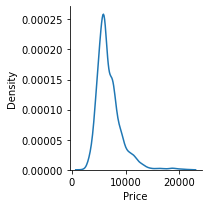

<Figure size 432x288 with 0 Axes>

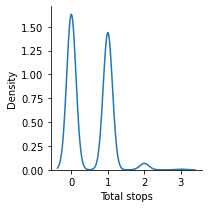

<Figure size 432x288 with 0 Axes>

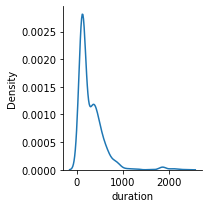

In [31]:
for col in df.select_dtypes(include=['float64','int64','int32']):
    plt.figure()
    sns.displot(df[col],kind='kde',height=3)
    plt.show()

In [32]:
numerical_features = df.select_dtypes(exclude=['object']).copy()
print(numerical_features.columns)

Index(['Price', 'Total stops', 'duration'], dtype='object')


In [33]:
categorical_features = df.select_dtypes(include=['object']).copy()
print(categorical_features.columns)

Index(['Airline name', 'Departure city', 'Arrival city', 'Route dummy',
       'Departure', 'Arrival'],
      dtype='object')


## EDA

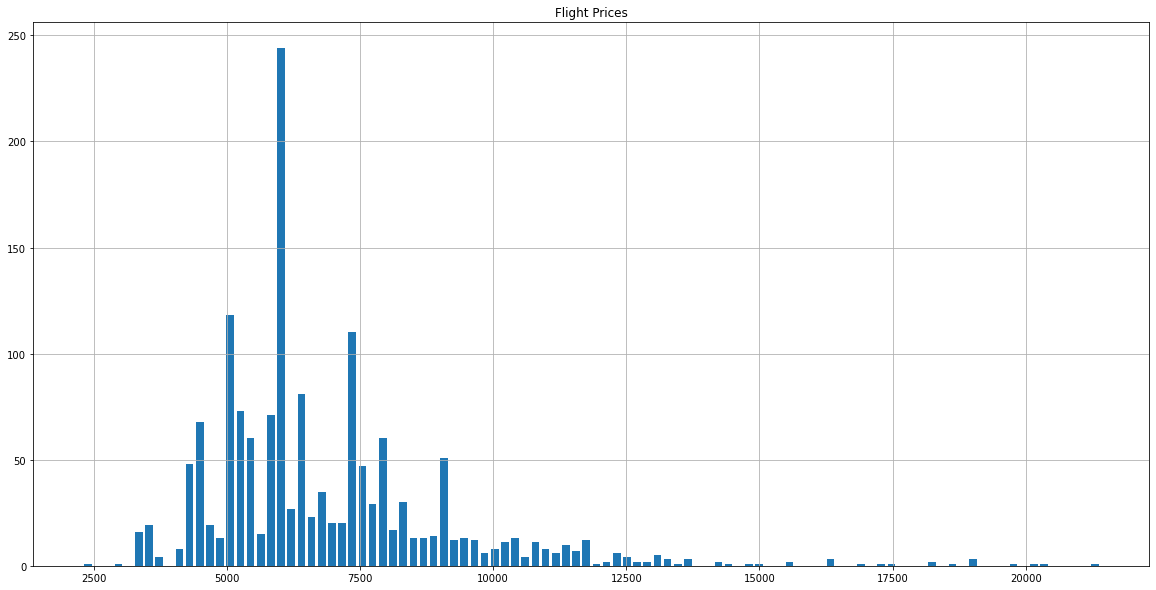

In [34]:
# Looking at distribution of flight price, which is our target variable.
# We can observe that the distribution is right skewed

df['Price'].hist(bins=100,figsize=(20,10),rwidth = 0.75)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Flight Prices')
plt.show()

<AxesSubplot:>

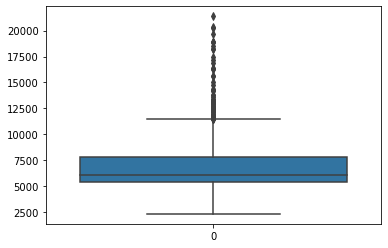

In [35]:
sns.boxplot(data=df['Price'])

<AxesSubplot:>

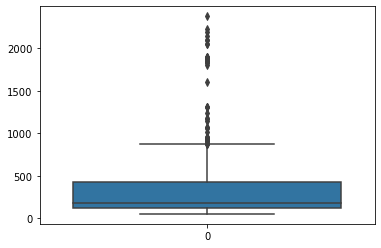

In [36]:
sns.boxplot(data=df['duration'])

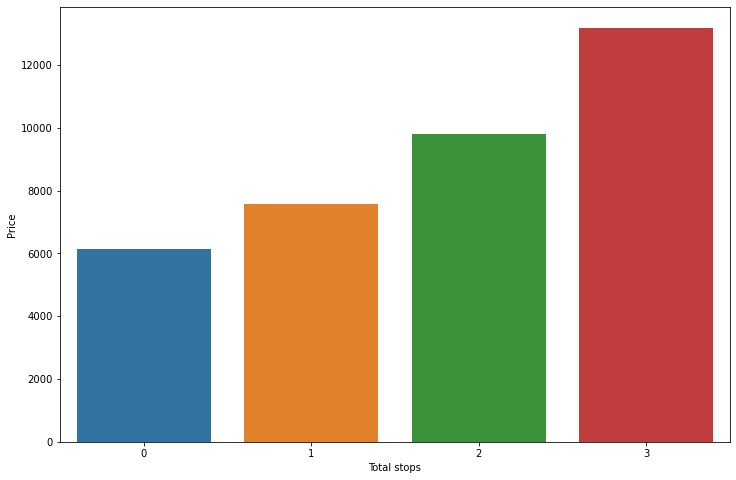

In [37]:
df_2 = df.groupby('Total stops').mean()
df_2.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='Total stops', y='Price', data=df_2,ax=ax);

As stops increase, the price of flight also increases

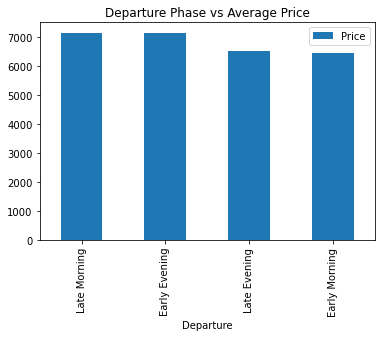

In [38]:
df_tf_1 = pd.DataFrame(df.groupby(['Departure'])['Price'].mean().sort_values(ascending = False))
df_tf_1.plot.bar()
plt.ticklabel_format(style='plain', axis='y')
plt.title('Departure Phase vs Average Price')
plt.show()

There is not a lot of difference in prices according to time of flight.

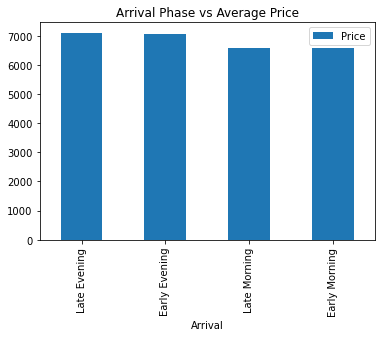

In [39]:
df_tf_2 = pd.DataFrame(df.groupby(['Arrival'])['Price'].mean().sort_values(ascending = False))
df_tf_2.plot.bar()
plt.ticklabel_format(style='plain', axis='y')
plt.title('Arrival Phase vs Average Price')
plt.show()

There is not a lot of difference in prices according to time of flight.

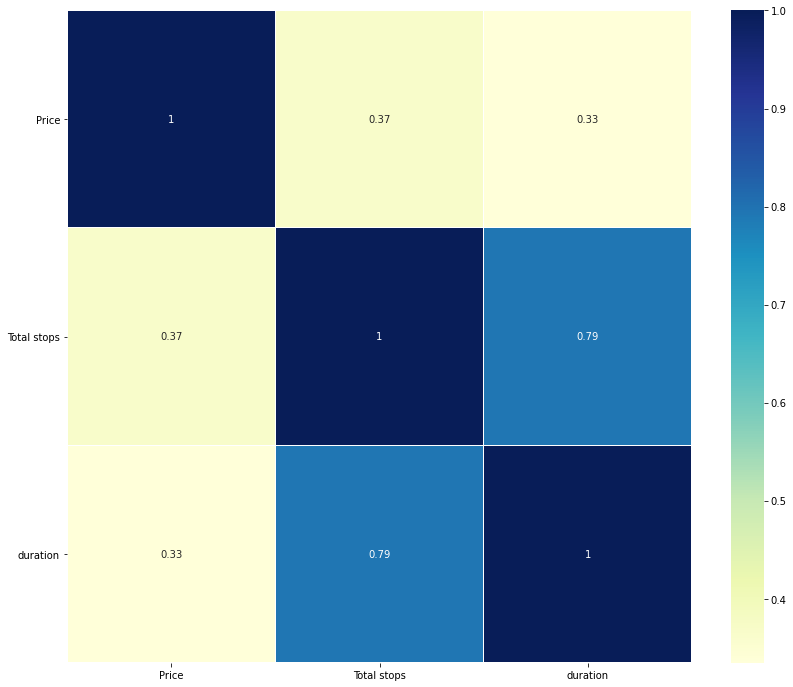

In [40]:
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0); # Checkign co-relation

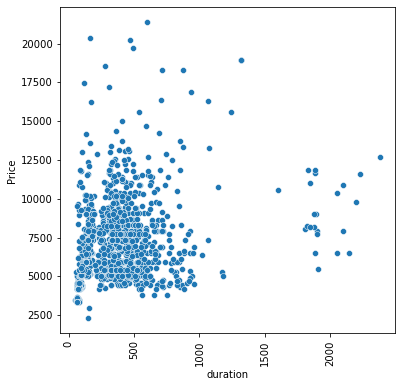

In [41]:
f,ax1 = plt.subplots(figsize = (6,6))
sns.scatterplot(y = df.Price, x = df['duration'])
plt.xticks(rotation = 90)
plt.show()

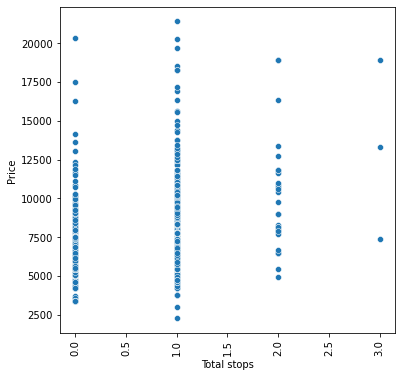

In [42]:
f,ax1 = plt.subplots(figsize = (6,6))
sns.scatterplot(y = df.Price, x = df['Total stops'])
plt.xticks(rotation = 90)
plt.show()

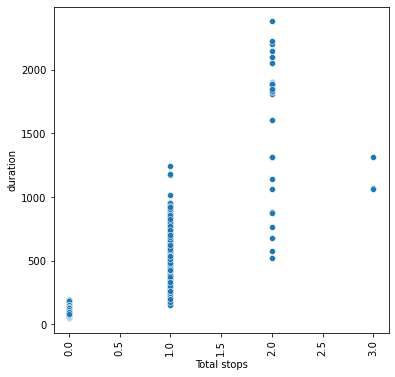

In [43]:
f,ax1 = plt.subplots(figsize = (6,6))
sns.scatterplot(y = df.duration, x = df['Total stops'])
plt.xticks(rotation = 90)
plt.show()

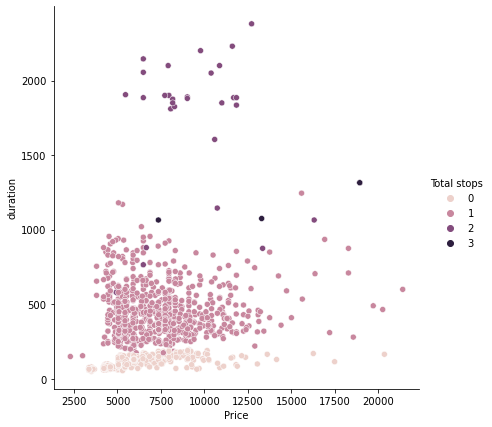

In [44]:
sns.pairplot(data = df, x_vars=['Price'], y_vars=['duration'], kind = 'scatter', diag_kind= None, height = 6, hue = 'Total stops')

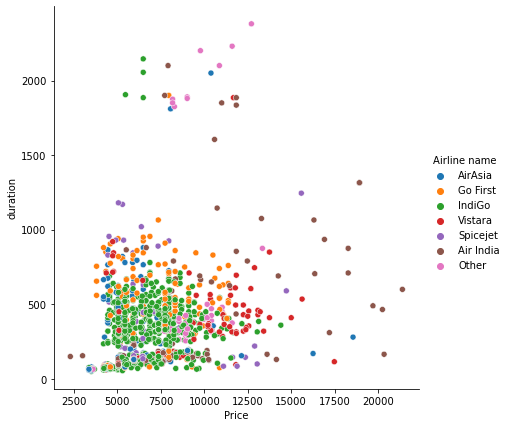

In [45]:
sns.pairplot(data = df, x_vars=['Price'], y_vars=['duration'], kind = 'scatter', diag_kind= None, height = 6, hue = 'Airline name')

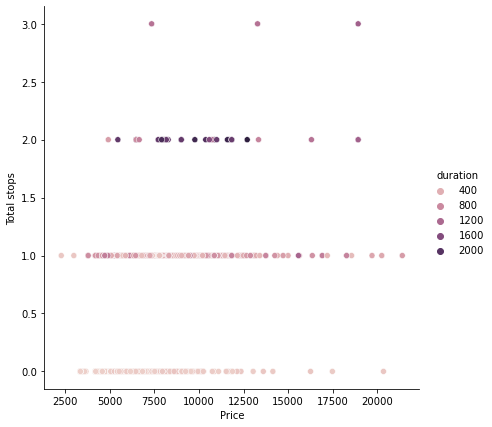

In [46]:
sns.pairplot(data = df, x_vars=['Price'], y_vars=['Total stops'], kind = 'scatter', diag_kind= None, height = 6, hue = 'duration')

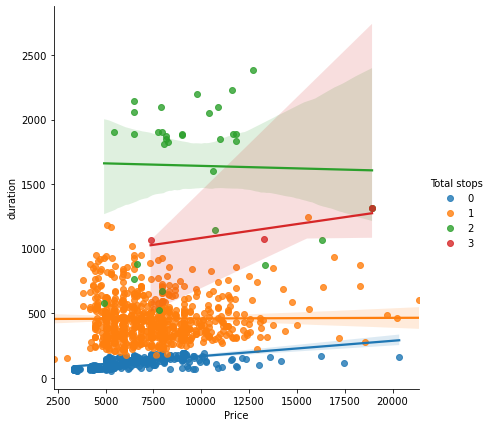

In [47]:
sns.pairplot(data = df, x_vars=['Price'], y_vars=['duration'], kind = 'reg', diag_kind= None, height = 6, hue = 'Total stops')

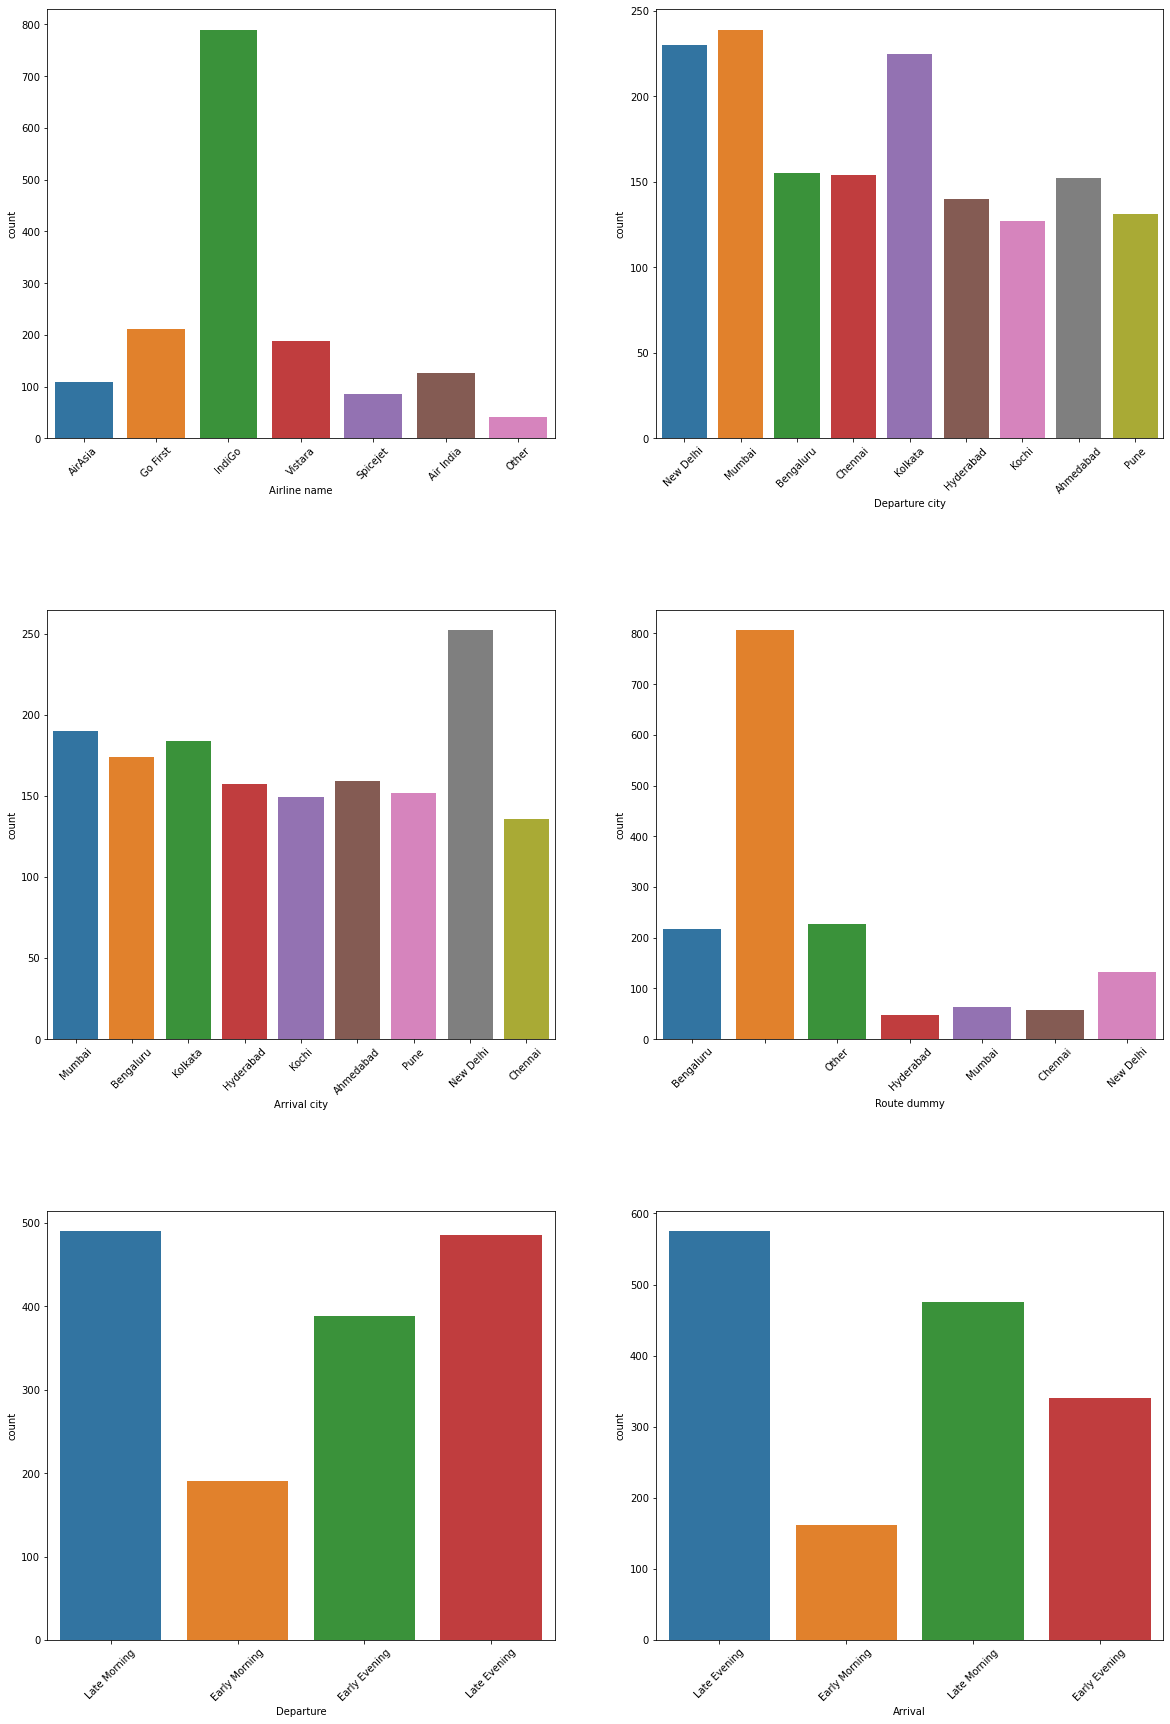

In [48]:
fig, ax = plt.subplots(3, 2, figsize=(20, 30))
for variable, subplot in zip(categorical_features, ax.flatten()):
    sns.countplot(data = df, x = categorical_features[variable], ax=subplot)
    plt.subplots_adjust(wspace=0.2,hspace=0.4)
    for label in subplot.get_xticklabels():
        label.set_rotation(45)

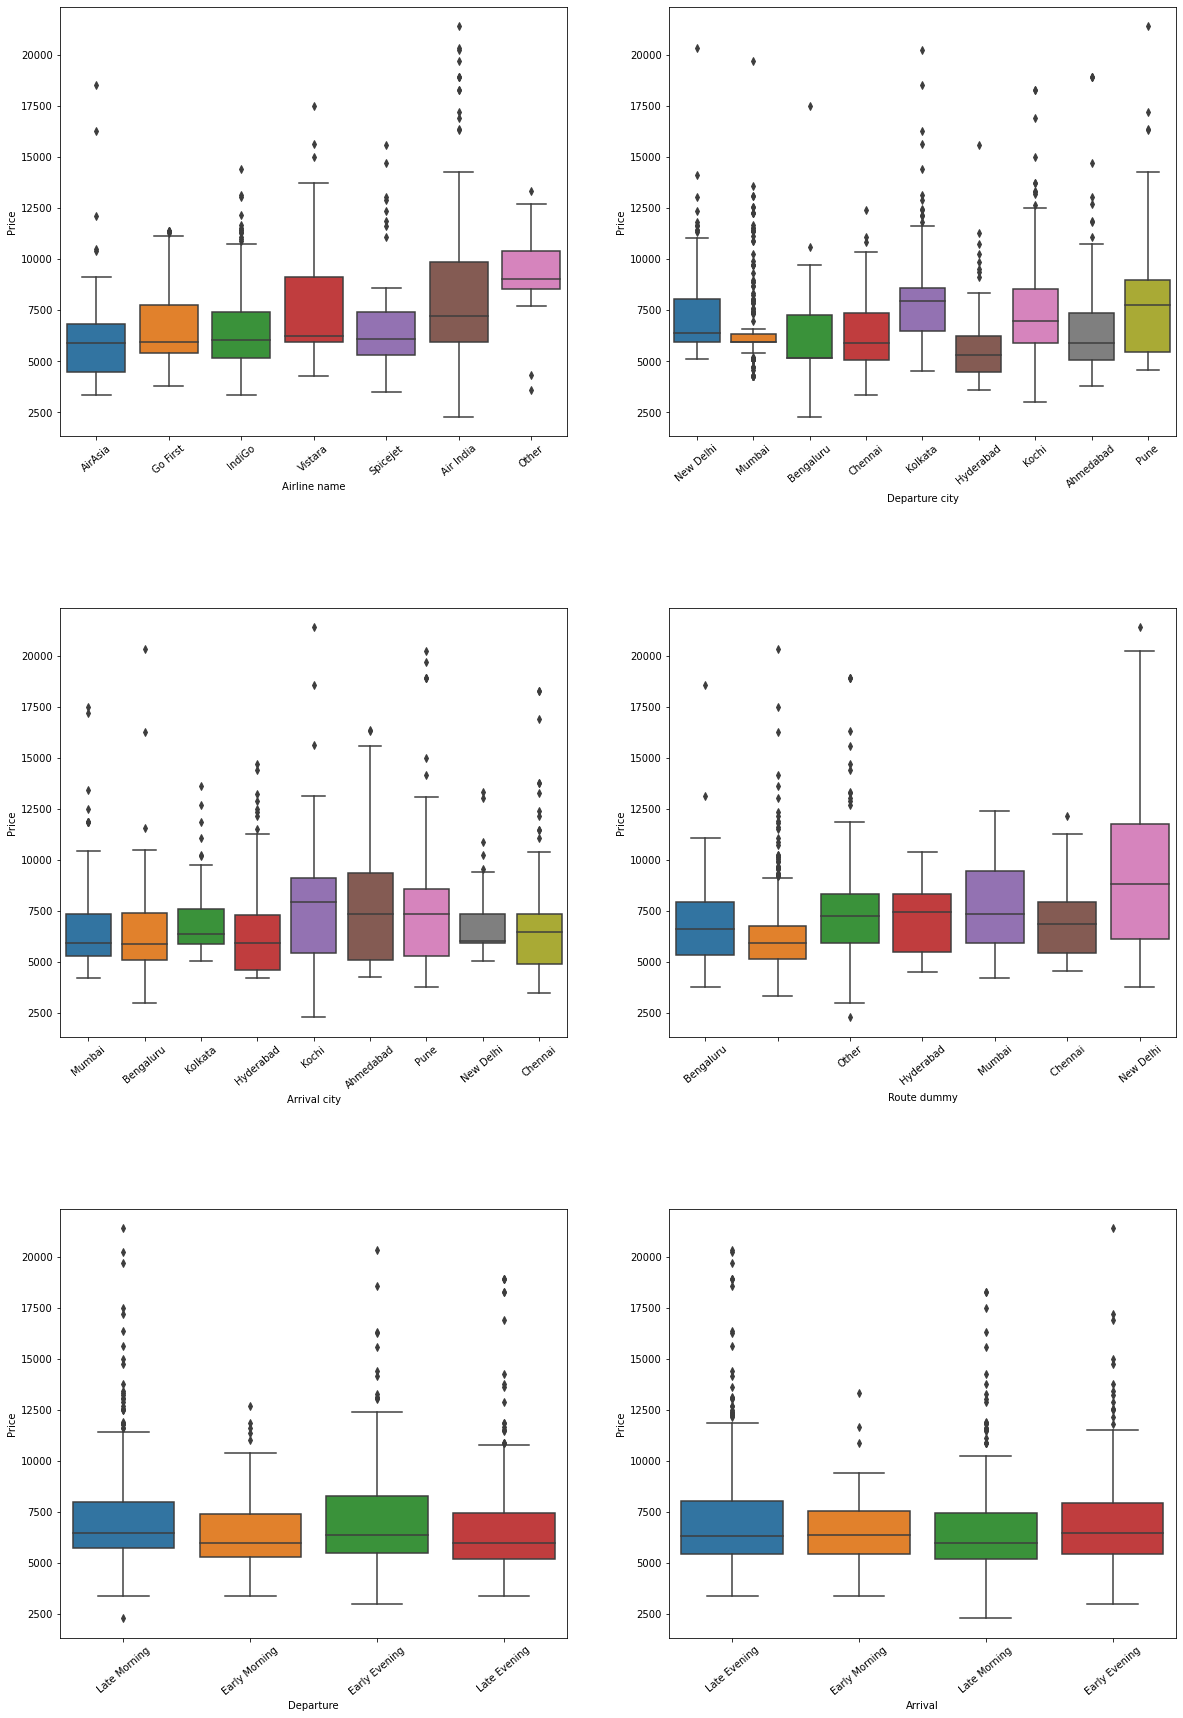

In [49]:
fig, ax = plt.subplots(3, 2, figsize=(20, 30))
for var, subplot in zip(categorical_features, ax.flatten()):
    sns.boxplot(x=var, y='Price', data=df, ax=subplot)
    plt.subplots_adjust(wspace=0.2,hspace=0.4)
    for label in subplot.get_xticklabels():
        label.set_rotation(40)

Skew 1.9194805890460838


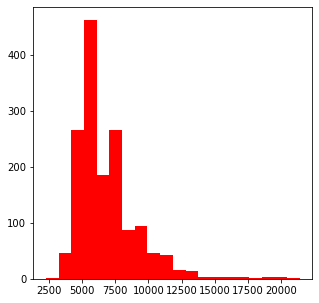

In [50]:
fig = plt.figure(figsize=(5,5))

print ("Skew", df.Price.skew())
plt.hist(df.Price,  color='red',bins=20)
plt.show() # Checking skew of target variable

Skew of Log-Transformed: 0.5739266313293612


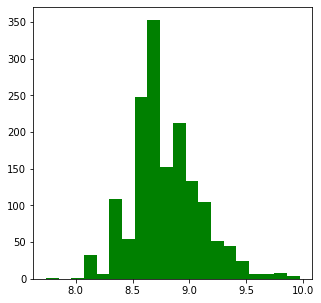

In [51]:
fig = plt.figure(figsize=(5,5))

print ("Skew of Log-Transformed:", np.log1p(df.Price).skew())
plt.hist(np.log1p(df.Price), color='green', bins =20)
plt.show() # Fixing the skew by taking log

In [52]:
df.describe() # Basic statistical infrence of data

,Price,Total stops,duration
count,1553.000000,1553.000000,1553.000000
mean,6876.605924,0.506117,310.592402
std,2334.948178,0.551586,295.706394
min,2292.000000,0.000000,50.000000
25%,5356.000000,0.000000,125.000000
50%,6079.000000,0.000000,175.000000
75%,7796.000000,1.000000,425.000000
max,21393.000000,3.000000,2380.000000


In [53]:
df[['Price']].idxmin() # Cheapest flight ID loc

Price    532
dtype: int64

In [54]:
df.iloc[532] # Deatils of the cheapest flight

Airline name         Air India
Departure city       Bengaluru
Arrival city             Kochi
Route dummy              Other
Price                     2292
Total stops                  1
duration                   150
Departure         Late Morning
Arrival           Late Morning
Name: 532, dtype: object

In [55]:
df[['Price']].idxmax() # Costliest flight ID loc

Price    1532
dtype: int64

In [56]:
df.iloc[1532] # Details of the costliest flight

Airline name          Air India
Departure city             Pune
Arrival city              Kochi
Route dummy           New Delhi
Price                     21393
Total stops                   1
duration                    600
Departure          Late Morning
Arrival           Early Evening
Name: 1532, dtype: object

In [57]:
df.shape # we still have more than 1500 data points

(1553, 9)

Skew of Log-Transformed 0.5739266313293612


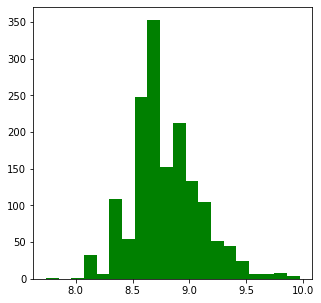

In [58]:
fig = plt.figure(figsize=(5,5))

print ("Skew of Log-Transformed", np.log1p(df.Price).skew())
plt.hist(np.log1p(df.Price), color='green', bins =20)
plt.show() # Fixing the skew by taking log

In [59]:
df['Price'] = np.log(df['Price']) # taking lof of price as it reduces skewness

In [60]:
df['Price'].skew()

0.5737641163348534

### Pre processing pipeline

In [61]:
df.columns

Index(['Airline name', 'Departure city', 'Arrival city', 'Route dummy',
       'Price', 'Total stops', 'duration', 'Departure', 'Arrival'],
      dtype='object')

Defining a dummy function and creating dummies for the folllowing categorical coulmns.

In [62]:
# Defining the map function
def dummies(x,df):
    temp = pd.get_dummies(df[x], drop_first = True)
    df = pd.concat([df, temp], axis = 1)
    df.drop([x], axis = 1, inplace = True)
    return df
# Applying the function to the df

df = dummies('Airline name',df)
df = dummies('Departure city',df)
df = dummies('Arrival city',df)
df = dummies('Route dummy',df)

## Buliding the model

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, cross_val_predict
import sklearn.metrics as sm
from math import e
# Importing useful libraries

80/20 split in training and testing data

In [64]:
X=df.drop(['Price','Departure','Arrival'], axis = 1, inplace = False)
y=df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

print("X Train Shape ",X_train.shape)
print("Y Train Shape ",y_train.shape)

print("X Test Shape ",X_test.shape)
print("Y Test Shape ",y_test.shape)

X Train Shape  (1242, 30)
Y Train Shape  (1242,)
X Test Shape  (311, 30)
Y Test Shape  (311,)


### Decision tree regressor

In [65]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=5)
dtr.fit(X_train, y_train)
y_pred_dt = dtr.predict(X_test)
dtr.score(X_test, y_test)

0.39556319719295796

In [66]:
scr = cross_val_score(dtr, X,y, cv=5)
print(scr.mean())

-0.11815335852946232


In [67]:
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred_dt), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred_dt), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred_dt), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred_dt), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred_dt), 2))

Mean absolute error = 0.13
Mean squared error = 0.06
Median absolute error = 0.04
Explain variance score = 0.4
R2 score = 0.4


### Random forest regression

In [68]:
rfr = RandomForestRegressor(random_state=1)
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)
rfr.score(X_test, y_test)

0.5725469207884493

In [69]:
scr = cross_val_score(rfr, X,y, cv=5)
print(scr.mean())

0.17809715365598747


In [70]:
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred_rfr), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred_rfr), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred_rfr), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred_rfr), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred_rfr), 2))

Mean absolute error = 0.12
Mean squared error = 0.04
Median absolute error = 0.06
Explain variance score = 0.57
R2 score = 0.57


### Support vector regression

In [71]:
from sklearn.svm import SVR
svr = SVR().fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
svr.score(X_test, y_test)

0.36473493779213995

In [72]:
scr = cross_val_score(svr, X,y, cv=5)
print(scr.mean())

0.21760322286447437


In [73]:
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred_svr), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred_svr), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred_svr), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred_svr), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred_svr), 2))

Mean absolute error = 0.18
Mean squared error = 0.06
Median absolute error = 0.12
Explain variance score = 0.36
R2 score = 0.36


### Lasso regression

In [74]:
from sklearn import linear_model
lassoReg = linear_model.Lasso(alpha=0.1).fit(X_train,y_train)
y_pred_lasso = lassoReg.predict(X_test)
lassoReg.score(X_test,y_test)

0.09062796471381451

In [75]:
scr = cross_val_score(lassoReg, X,y, cv=5)
print(scr.mean())

0.03229855418988625


In [76]:
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred_lasso), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred_lasso), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred_lasso), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred_lasso), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred_lasso), 2))

Mean absolute error = 0.23
Mean squared error = 0.09
Median absolute error = 0.18
Explain variance score = 0.09
R2 score = 0.09


### Linear regression

In [77]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize=True).fit(X, y)
y_pred_lr = lr.predict(X_test)
lr.score(X_test,y_test)

0.43660242440566654

In [78]:
cr = cross_val_score(lr, X,y, cv=5)
print(scr.mean())

0.03229855418988625


In [79]:
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred_lr), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred_lr), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred_lr), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred_lr), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred_lr), 2))

Mean absolute error = 0.18
Mean squared error = 0.06
Median absolute error = 0.15
Explain variance score = 0.44
R2 score = 0.44


### Hyper paramter tuning

Hyper parameter tuning on random forest model.

In [80]:
from sklearn.model_selection import GridSearchCV

In [81]:
parameters = { 'n_estimators' : [100,150],
               'min_samples_leaf' : [1,2], 
              'min_samples_split': [2,3],
              'criterion': ['mse','mae']
}

In [82]:
GCV = GridSearchCV(RandomForestRegressor(),parameters,cv=5)

In [83]:
GCV.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['mse', 'mae'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [100, 150]})

In [84]:
GCV.best_params_

{'criterion': 'mae',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 150}

In [85]:
mod = RandomForestRegressor(min_samples_leaf= 2, min_samples_split =2, n_estimators = 150, criterion='mae')
mod.fit(X_train,y_train)
pred = mod.predict(X_test)
mod.score(X_test,y_test)

0.6177385219716642

In [86]:
y_test = e**y_test # taking antilog pf price and prediction after the models have built a model
pred = e**pred

In [87]:
df_p = pd.DataFrame({})
df_p['Actual'] = y_test
df_p['Prediction'] = pred

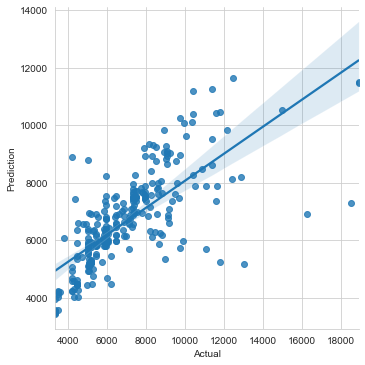

In [88]:
sns.set_style('whitegrid')
sns.lmplot(x ='Actual', y ='Prediction', data = df_p)


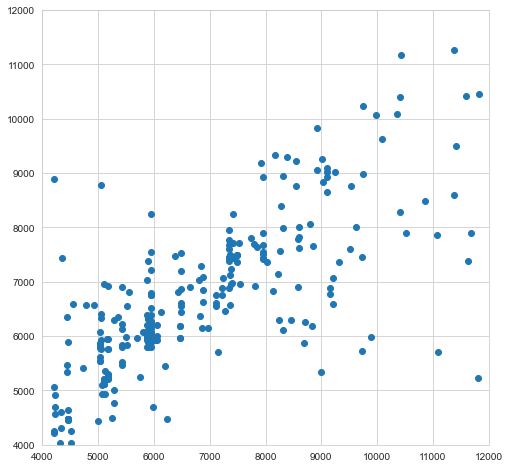

In [89]:
plt.figure(figsize=(8,8))
plt.xlim([4000, 12000])
plt.ylim([4000, 12000])
plt.scatter(y_test,pred)

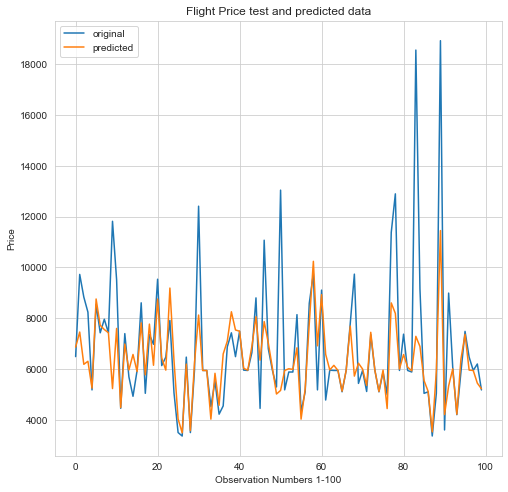

In [90]:
number_of_observations=100
x = 0
x_ax = range(len(y_test[x:x+number_of_observations]))
plt.figure(figsize =(8,8))
plt.plot(x_ax, y_test[x:x+number_of_observations], label="original")
plt.plot(x_ax, pred[x:x+number_of_observations], label="predicted")
plt.title("Flight Price test and predicted data")
plt.xlabel('Observation Numbers 1-100')
plt.ylabel('Price')
plt.legend()
plt.show()

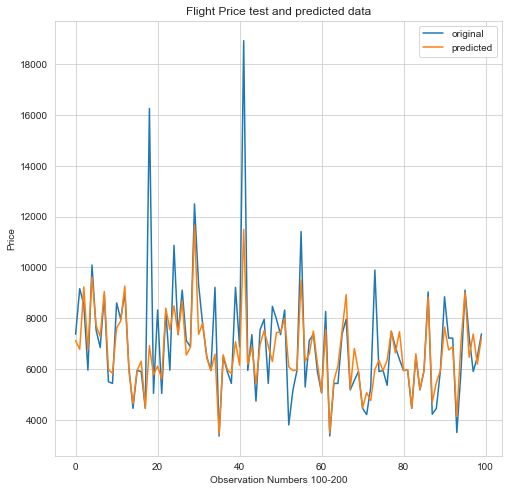

In [91]:
number_of_observations=100
x = 100
x_ax = range(len(y_test[x:x+number_of_observations]))
plt.figure(figsize =(8,8))
plt.plot(x_ax, y_test[x:x+number_of_observations], label="original")
plt.plot(x_ax, pred[x:x+number_of_observations], label="predicted")
plt.title("Flight Price test and predicted data")
plt.xlabel('Observation Numbers 100-200')
plt.ylabel('Price')
plt.legend()
plt.show()

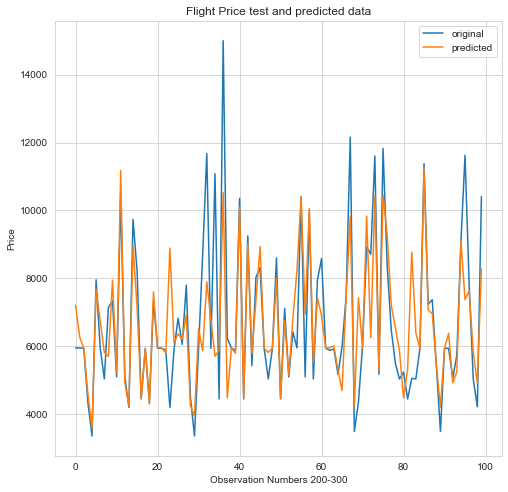

In [92]:
number_of_observations=100
x = 200
x_ax = range(len(y_test[x:x+number_of_observations]))
plt.figure(figsize =(8,8))
plt.plot(x_ax, y_test[x:x+number_of_observations], label="original")
plt.plot(x_ax, pred[x:x+number_of_observations], label="predicted")
plt.title("Flight Price test and predicted data")
plt.xlabel('Observation Numbers 200-300')
plt.ylabel('Price')
plt.legend()
plt.show()

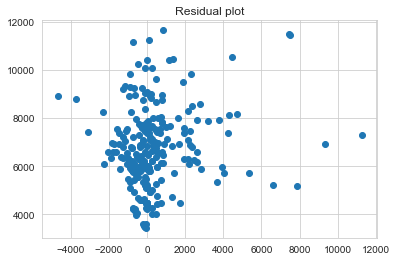

In [93]:
plt.scatter(y_test-pred,pred)
plt.title('Residual plot')
plt.show()

Consuidering that this mode contains 72 different flight paths over 1500 data points, with the help of these graphs we can see that the model is performing well.

On average this data has 1502/72 = 21 data points for each flight path.

While the reality is that on average most of the flights are dominated by popular routes like Delhi to Bombay, Bombay to Delhi etc. among the most popular cities.

And the paths with less frequent flights like Ahemdabad to Pune has far less that 5 flight on that path. 

To get a more accurate mode, much more data is required.